# Clustering Basketball Players
### Roland Zhou & Mohammad Radiyat


## Introduction 
### Goal
In sports, scouting new players is a constant problem that teams must deal with to maintain their competitive advantage. Usually coaches rely on various signals to make scouting decisions, including player physique, performance in college leagues, and their own intuition and prior experience. However, machine learning, specifically clustering, may be able to find solutions to this problem much more efficiently and/or effectively. The intuition behind clustering is that coaches would want their teams to be as well-balanced as possible instead of focusing on one specific kind of player. Ideally clustering would separate players out such that coaches could just pick somewhat evenly from clusters for a well-balanced selection of players. 

The goal of this project, then, is to try to see how effectively we can cluster basketball players into groups and then make sense of the clustering using various visualizations. Some researchers have tried using Gaussian mixture models [[footballresearch2017](http://www.redalyc.org/pdf/710/71051616004.pdf)] on various sources of player statistics information to cluster players together to determine how to separate different kinds of players most optimally. We will also demonstrate the GMM using Edward, and then improve upon on the GMM with other more expressive models in order to separate players.

An example of separation we would like to achieve can be seen in this projection of player stats onto 2 dimensions, using t-SNE [[t-SNE](http://www.jmlr.org/papers/v9/vandermaaten08a.html)]. Here, players are separated on the projected space as evidenced by colors based on player positions.

### Image Here

### Background
Professional basketball is a 5-on-5 team sport where each player on a team normally takes up a different position. Players aim to put the ball into a basket on opposing sides of the court. Shots made close to the basket are worth 2 points, and shots made from far enough away from the basket are worth 3 points (referred to as 3-pointers). 

Some important player stats that we use are:
* Points scored
* Rebounds - # times a player received the ball off of a missed scoring attempt
* Assists - # times a player passed a ball to another player who scored
* Steals - # times a player took the ball from the opposing team during normal play
* Blocks - # times a player successfully blocked a shot from scoring

The 5 positions that players can occupy are:
* Point guard - usually the team's best passer and ball handler. They focus on assists and steals, and are responsible for leading the team on plays
* Shooting guard - players who focus primarily on shooting, especially 3-pointers. 
* Power forward - prolific scorers able to score close to the basket or through shooting from afar. They rely on strength to guard larger players and athleticism to guard quick players. 
* Small forward - versatile players who are able to do a little bit of everything, including shooting, passing, foul shots, and aggressively scoring close to the basket.
* Center - usually the tallest player, focusing on scoring close to the basket and on rebounds and blocks

![](https://i.pinimg.com/originals/6a/85/28/6a85281a70ff8a6b5391681091a87a11.gif)

Fig 1. Basketball positions

### Data

The data was scraped from [basketball-reference.com](basketball-reference.com). It includes seasonal statistical data from the 1950s until 2017 for each active player. Statistics include those listed above, position, age, team, and a variety of other statistics. 

# Gaussian Mixture Models


Gaussian Mixture Models (GMMs) are one of the most widely used types of clustering methods. They assume that data points $x_1, x_2...x_n$ are all independent identically distributed data points, and that they come from a mixture density $p(x) = \sum_{k=1}^K \pi_kp_k(x)$ where $p_k(x)$ is the normal probability density function of the observations in group $k$ and the $\pi$s are the probabilities that an observation comes from the $k^{th}$ mixture component. Each of the normal probability distributions has its own mean $\mu_k$ and deviation $\sigma_k$. The $k$-dimensional $\pi$ mixes the Gaussian components and is defined such that $\sum_1^K\pi_k = 1$. 

A GMM posits a fixed number of latent gaussian mixture components onto the data, with learnable local membership probabilities as well as global mixture parameters. While commonly used in social sciences, GMM is also limited by the simplicity that makes it widely applicable. Some of the ways we can improve upon the GMM are determining the number of clusters from the data and improving the expressivity of each mixture distribution (something more complex than a gaussian). The "variational autoencoder" is a generative neural network that meets both these improvements, which is what we'll use afterwards. 

## First Run (raw data, no scaling)

### Modeling

We model our raw data without scaling it using a Gaussian mixture model to get a baseline. We take note of the number of training samples $N$ and number of features $D$. 

In [0]:
import edward as ed
import pandas as pd
import numpy as np
import tensorflow as tf

In [0]:
from src.data_utils import BasketballDataset

dataset = BasketballDataset('data/player_season_stats.csv', standardize=True)

For a Gaussian mixture model, the likelihood of a data point $x_n$ is 
> $p(x_n|\pi, \mu, \sigma) = \sum_{k=1}^K\pi_k Normal(x_n|\mu_k, \sigma_k)$

The prior on $\pi$ is defined as 
> $p(\pi) = Dirichlet(\pi|\alpha_k)$ 

where $\alpha = 1$. Each component's mean's prior is defined as 
> $p(\mu_k) = Normal(\mu_k|0, I)$

where the covariance is $I$, or the identity matrix. Lastly, each component's variance's prior is defined as 
>$p(\sigma^2_k) = InverseGamma(\sigma^2_k|a,b)$

where $a$ and $b$ are $D$-length vectors of 1s. 

Then we can define the distribution of the mixture conditional on mixture assignments with a latent variable for the assignments using Edward's ParamMixture class, which takes mixing probabilities, component parameters, and component distributions as inputs. Here is an pseudo Edward code for a simple GMM model:

In [0]:
raise Exception("Do not run")

pi = Dirichlet(tf.ones(K))
mu = Normal(tf.zeros(D), tf.ones(D), sample_shape=K)
sigmasq = InverseGamma(tf.ones(D), tf.ones(D), sample_shape=K)
x = ParamMixture(pi, {'loc': mu, 'scale_diag': tf.sqrt(sigmasq)},
                 MultivariateNormalDiag,
                 sample_shape=N)
z = x.cat

### Model Definition and Inference

We define a Gaussian Mixture Model with k = 5 clusters. We will simultaneously define its inference graph. For inference, we use Gibbs sampling to draw from the conditionals of each distribution. We set up empirical random variables to estimate the posterior using the sampling. 

In [0]:
from src.gmm import GMM

x_train = dataset.x_train
mc_samples = 500
with tf.variable_scope('reuse', reuse=tf.AUTO_REUSE):
      gmm_model = GMM(n=x_train.shape[0], 
                      xdim=x_train.shape[1],
                      n_mixtures=5,
                      mc_samples=mc_samples)

Next we run Gibbs sampling using a training loop. 

In [0]:
inference = gmm_model.inference

sess = ed.get_session()
tf.global_variables_initializer().run()

t_ph = tf.placeholder(tf.int32, [])

for _ in range(inference.n_iter):
    info_dict = inference.update(gmm_model.make_feed_dict_trn(dataset.x_train))
    inference.print_progress(info_dict)

/usr/local/lib/python3.6/dist-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


500/500 [100%] ██████████████████████████████ Elapsed: 203s | Acceptance Rate: 1.000


### Criticism

We first look at how well-separated the clusters are by using PCA to reduce the dimensionality of the cluster means to 2 and then using a scatterplot. The clusters seem to be fairly well-separated. Next we plot the log likelihoods of each data point, reduced to two dimensions using PCA. We assign each data point to a the cluster that yields highest likelihood for that point, and plot that.

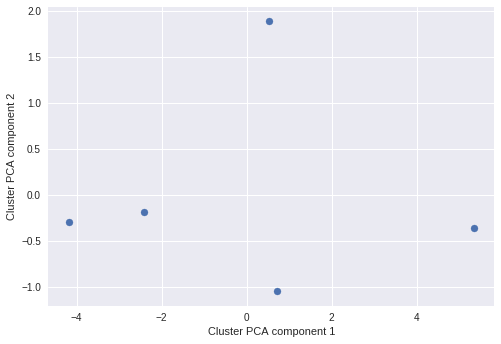

In [0]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

running_mean = gmm_model.eval_ops['post_running_mu']
sample_timesteps = gmm_model.sample_t_ph
cluster_means = sess.run(running_mean, 
                         feed_dict={
                             sample_timesteps: info_dict['t']-1
                         })

pca_model = PCA(n_components=2)
stats_transformed = pca_model.fit_transform(cluster_means)
plt.scatter(stats_transformed[:,0], stats_transformed[:, 1])
plt.xlabel('Cluster PCA component 1');
plt.ylabel('Cluster PCA component 2');

Next we plot the log likelihoods of each data point, reduced to two dimensions using PCA. We assign each data point to a the cluster that yields highest likelihood for that point, and plot that. 

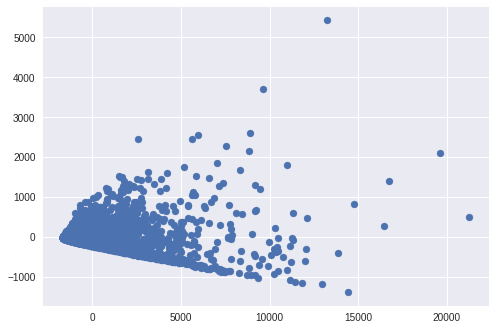

In [0]:
sampled_post_log_prob = gmm_model.eval_ops['post_log_prob'] # Shape [N, K]
sampling_inputs = gmm_model.make_feed_dict_test(dataset.x_train)

log_probs = sess.run(sampled_post_log_prob, sampling_inputs)

log_probs_2d = PCA(n_components=2).fit_transform(log_probs)
plt.scatter(log_ll_values_2d[:,0], log_ll_values_2d[:, 1])

One thing that we are interested in is whether clustering separates players by position well, so we count players per position per cluster.

For each player (except for players that appear only once in our data), we count the proportion of times he is placed into each of the 5 clusters, and plot the max of these proportions per player on a histogram. We do this as a check on how confident the clustering is per player. 

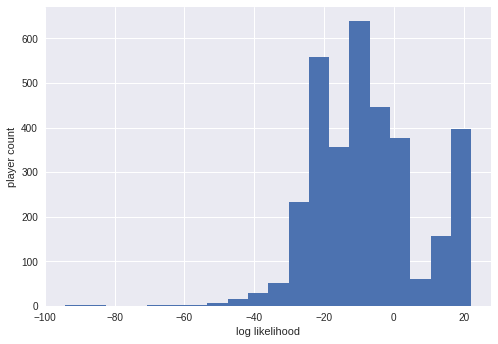

In [0]:
max_log_liks = np.max(log_probs, 1)

plt.hist(max_log_liks, bins=20)
plt.xlabel('log likelihood')
plt.ylabel('player count')
plt.show()

We visualize how well the clusters partition the data into counts, as well as how the counts vary between positions.

In [0]:
from collections import Counter

clusters = np.argmax(log_probs, 1)

counts = Counter(clusters)
counts.most_common(5)

[(1, 819), (2, 753), (4, 742), (3, 647), (0, 372)]

The clusters don't seem to separate by position too well; it seems that each cluster has about even numbers of players of each position. Also, the first cluster has a very large majority of the players, so this run does not cluster well. 

In [0]:
positions = dataset.x_train_info['Pos'].tolist()
pos_clusters = pd.DataFrame(list(zip(positions, clusters)), columns=['Pos', 'Cluster'])
pos_clusters = pos_clusters[pos_clusters['Pos'].isin(['C', 'PF', 'PG', 'SF', 'SG'])]
print(pos_clusters.groupby(['Pos', 'Cluster']).size())

Pos  Cluster
C    0          220
     1           24
     2          143
     3          139
     4          134
PF   0          138
     1           98
     2          169
     3          126
     4          140
PG   0            1
     1          210
     2          163
     3          104
     4          148
SF   0            9
     1          212
     2          132
     3          129
     4          157
SG   0            1
     1          260
     2          139
     3          140
     4          149
dtype: int64


The log-likelihood scatterplot takes a interesting shape, but we still have the issue of several points having positive log-likelihoods. 

We count number of points per cluster again to make sure that there is at least some level of spread of data points across clusters. 

This time it seems like there are log-likelihood numbers that are greater than 0, which shouldn't be happening given that all the likelihoods should be between 0 and 1. After some trial and error we were unable to learn why this happens.

As before we look at how each cluster separates positions with a heatmap, and look at how well players are clustered with themselves using a histogram. 

Text(0,0.5,'player count')

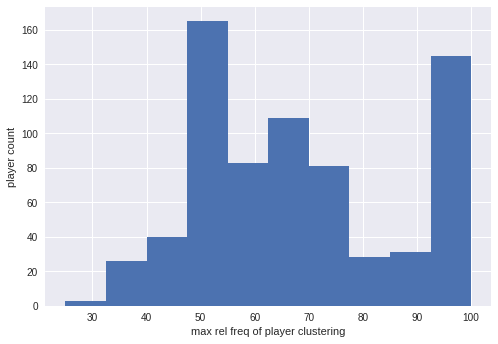

In [0]:
#get dataframe of players and their respective clusters
players = dataset.x_train_info['Player'].tolist()
player_clusters = pd.DataFrame(list(zip(players, clusters)), columns=['Player', 'Cluster'])

#get rid of players who appear once
player_clusters = player_clusters[player_clusters.groupby('Player').Player.transform(len) > 1]

#get relative frequency of each player's appearance in each cluster
player_clusters = pd.DataFrame(player_clusters.groupby(['Player', 'Cluster']).size())
player_clusters = player_clusters.groupby(['Player', 'Cluster']).agg({0: 'sum'})
player_clusters = player_clusters.groupby(level=0)
player_clusters = pd.DataFrame(player_clusters.apply(lambda x: 100 * x / float(x.sum())))

#only keep the max relative frequency per player; this is a decent gauge of how confidently they can be clustered
player_clusters = pd.DataFrame(player_clusters.groupby('Player').max())

#visualize
player_clusters[0].hist()
plt.xlabel('max rel freq of player clustering')
plt.ylabel('player count')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.


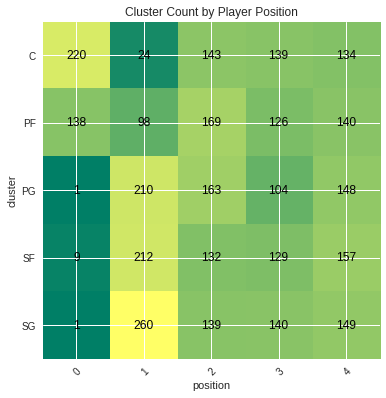

In [0]:
positions = ['C', 'PF', 'PG', 'SF', 'SG']
clusters = list(range(5))

pos_clusters_data = pos_clusters.groupby(['Pos', 'Cluster']).size().reshape([5, 5])

fig, ax = plt.subplots()
im = ax.imshow(pos_clusters_data, cmap = 'summer')

# We want to show all ticks...
ax.set_xticks(np.arange(len(clusters)))
ax.set_yticks(np.arange(len(positions)))
# ... and label them with the respective list entries
ax.set_xticklabels(clusters)
ax.set_yticklabels(positions)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(positions)):
    for j in range(len(clusters)):
        text = ax.text(j, i, pos_clusters_data[i, j],
                       ha="center", va="center", color="black")

ax.set_title("Cluster Count by Player Position")
fig.tight_layout()
plt.xlabel('position')
plt.ylabel('cluster')
plt.show()

With scaled data, cluster 0 does a decent job picking out power forwards and centers over everyone else, which makes sense since those kinds of players are fairly similar. Cluster 1 pulls out the remaining three kinds of players. 

## Second Run (scaling & per-minute stats)

This time, we repeat the analysis but use stats per minute played instead of bulk stats. The data now has signals about player efficiency with respect to time. 

In [0]:
dataset = BasketballDataset('data/player_season_stats.csv', per_minute=True, standardize=True)

### Inference

We define the same GMM with Gibbs sampling as before. 

In [0]:
from src.gmm import GMM

x_train = dataset.x_train
mc_samples = 500
with tf.variable_scope('reuse', reuse=tf.AUTO_REUSE):
      gmm_model = GMM(n=x_train.shape[0], 
                      xdim=x_train.shape[1],
                      n_mixtures=5,
                      mc_samples=mc_samples)

In [0]:
inference = gmm_model.inference

sess = ed.get_session()
tf.global_variables_initializer().run()

t_ph = tf.placeholder(tf.int32, [])

for _ in range(inference.n_iter):
    info_dict = inference.update(gmm_model.make_feed_dict_trn(dataset.x_train))
    inference.print_progress(info_dict)

/usr/local/lib/python3.6/dist-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


500/500 [100%] ██████████████████████████████ Elapsed: 202s | Acceptance Rate: 1.000


### Criticism

We look at the cluster separation as before.

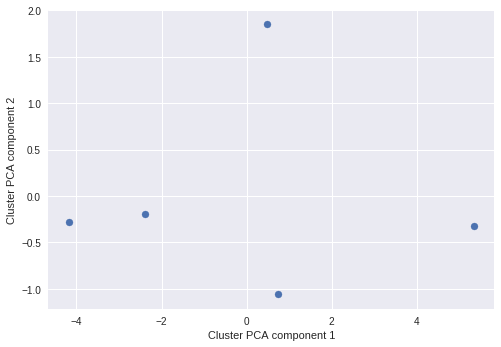

In [0]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

running_mean = gmm_model.eval_ops['post_running_mu']
sample_timesteps = gmm_model.sample_t_ph
cluster_means = sess.run(running_mean, 
                         feed_dict={
                             sample_timesteps: info_dict['t']-1
                         })

pca_model = PCA(n_components=2)
stats_transformed = pca_model.fit_transform(cluster_means)
plt.scatter(stats_transformed[:,0], stats_transformed[:, 1])
plt.xlabel('Cluster PCA component 1');
plt.ylabel('Cluster PCA component 2');

The clusters are, again, well-separated. We repeat the prior analysis for the log-likelihoods of each of our data points.

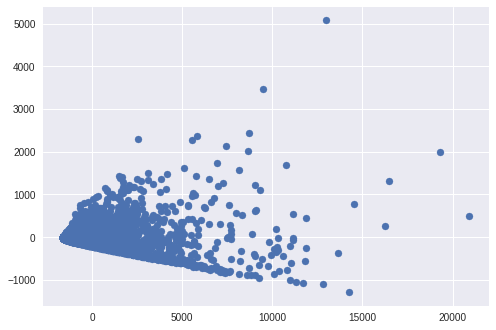

In [0]:
sampled_post_log_prob = gmm_model.eval_ops['post_log_prob'] # Shape [N, K]
sampling_inputs = gmm_model.make_feed_dict_test(dataset.x_train)

log_probs = sess.run(sampled_post_log_prob, sampling_inputs)

log_probs_2d = PCA(n_components=2).fit_transform(log_probs)
plt.scatter(log_ll_values_2d[:,0], log_ll_values_2d[:, 1])

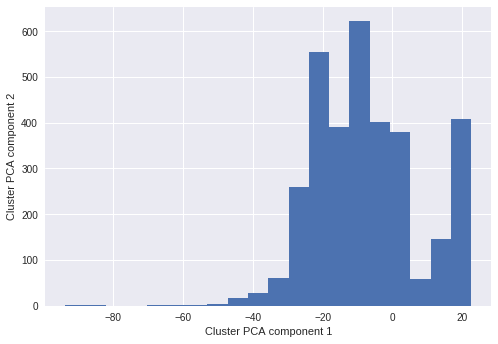

In [0]:
max_log_liks = np.max(log_probs, 1)

plt.hist(max_log_liks, bins=20)
plt.xlabel('log likelihood')
plt.ylabel('player count')
plt.show()

There are still many points for which the log-likelihood exceeds 0. 

We check membership numbers per cluster again. 

In [0]:
from collections import Counter

clusters = np.argmax(log_probs, 1)

counts = Counter(clusters)
counts.most_common(5)

[(2, 811), (1, 756), (0, 720), (4, 672), (3, 374)]

Lastly we again look at how each cluster separates positions with a heatmap, and look at how well players are clustered with themselves using a histogram.

In [0]:
positions = dataset.x_train_info['Pos'].tolist()
pos_clusters = pd.DataFrame(list(zip(positions, clusters)), columns=['Pos', 'Cluster'])
pos_clusters = pos_clusters[pos_clusters['Pos'].isin(['C', 'PF', 'PG', 'SF', 'SG'])]
print(pos_clusters.groupby(['Pos', 'Cluster']).size())

Pos  Cluster
C    0          130
     1          145
     2           24
     3          218
     4          143
PF   0          136
     1          169
     2           97
     3          140
     4          129
PG   0          142
     1          163
     2          209
     3            1
     4          111
SF   0          150
     1          133
     2          208
     3           11
     4          137
SG   0          148
     1          139
     2          258
     3            1
     4          143
dtype: int64


Text(0,0.5,'player count')

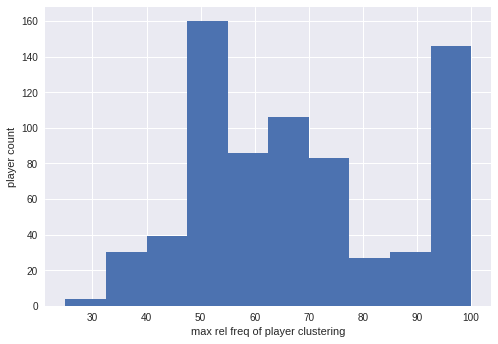

In [0]:
#get dataframe of players and their respective clusters
players = dataset.x_train_info['Player'].tolist()
player_clusters = pd.DataFrame(list(zip(players, clusters)), columns=['Player', 'Cluster'])

#get rid of players who appear once
player_clusters = player_clusters[player_clusters.groupby('Player').Player.transform(len) > 1]

#get relative frequency of each player's appearance in each cluster
player_clusters = pd.DataFrame(player_clusters.groupby(['Player', 'Cluster']).size())
player_clusters = player_clusters.groupby(['Player', 'Cluster']).agg({0: 'sum'})
player_clusters = player_clusters.groupby(level=0)
player_clusters = pd.DataFrame(player_clusters.apply(lambda x: 100 * x / float(x.sum())))

#only keep the max relative frequency per player; this is a decent gauge of how confidently they can be clustered
player_clusters = pd.DataFrame(player_clusters.groupby('Player').max())

#visualize
player_clusters[0].hist()
plt.xlabel('max rel freq of player clustering')
plt.ylabel('player count')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.


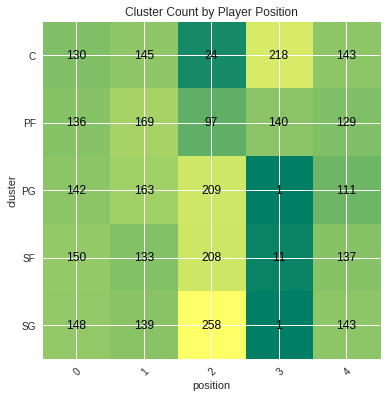

In [0]:
positions = ['C', 'PF', 'PG', 'SF', 'SG']
clusters = list(range(5))

pos_clusters_data = pos_clusters.groupby(['Pos', 'Cluster']).size().reshape([5, 5])


fig, ax = plt.subplots()
im = ax.imshow(pos_clusters_data, cmap = 'summer')

# We want to show all ticks...
ax.set_xticks(np.arange(len(clusters)))
ax.set_yticks(np.arange(len(positions)))
# ... and label them with the respective list entries
ax.set_xticklabels(clusters)
ax.set_yticklabels(positions)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(positions)):
    for j in range(len(clusters)):
        text = ax.text(j, i, pos_clusters_data[i, j],
                       ha="center", va="center", color="black")

ax.set_title("Cluster Count by Player Position")
fig.tight_layout()
plt.xlabel('position')
plt.ylabel('cluster')
plt.show()

This time, cluser 3 picks out centers and power forwards, while cluster 2 picks out the rest.

# VAE

![alt text](http://kvfrans.com/content/images/2016/08/vae.jpg)

The VAE  [[VAE]](https://arxiv.org/abs/1312.6114) assumes a latent variable z generates each of our observed data, x. The VAE itself is then a neural network that is designed to simultaneously learn how to encode x to z and decoding a sampled z to x. It learns how to do so by minimizing the KL divergence between the true posterior $P(z|x)$ and the variational approximation $Q(z|x)$, which is an encoder neural network. However, since we do not have access to the true posterior $P(z|x)$, we opt to equivalently maximize the ELBO, which can be further derived to require only $P(x|z)$ and $P(z)$.

$$KL(q_{ϕ}(z∣x)||p_{θ}(z∣x))$$
$$=E_{q_{ϕ}(z∣x)}[logq_{ϕ}(z∣x)−logp_{θ}(z∣x)]$$
$$=E_{q_{ϕ}(z∣x)}[logq_{ϕ}(z∣x)−logp_{θ}(z,x)]+logp_{θ}(x)$$
$$=KL(q_{ϕ}(z∣x)||p(z))-E_{q_{ϕ}(z∣x)}[logp_{θ}(x|z)]+logp_{θ}(x)$$
$$=−L(x;θ,ϕ)+logp_{θ}(x)$$

Since the VAE learns the function mapping x to its latent z using amortized inference, the VAE can be said to be nonparametric with respect to the parameters of the mixtures. Furthermore, thanks to the flexibility of neural networks, the generative process for x given a latent z can be arbitrarily complex, whereas for a GMM, this generative distribution is simply a multivariate gaussian.

In [0]:
import edward as ed
import pandas as pd
import numpy as np
import tensorflow as tf
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from edward.models import Bernoulli, Normal, Gamma, TransformedDistribution
from edward.util import Progbar

We read in our data and scale all stats to 0 and 1 using MinMax scaling. We will also keep watch for certain players.

Steph Curry and J.J. Reddick are both premier three pointer shooters, whereas DeAndre Jordan is your prototypical big man who has a strong paint presence and grabs lots of rebounds. Finally, Kobe Bryant is a prolific scoring-oriented wing player. These five players should be distant from each other on a latent space.

In [13]:
dataset = BasketballDataset('data/player_season_stats.csv', min_max=True)

players_to_watch = ['Stephen Curry', 'J.J. Reddick', 'DeAndre Jordan', 'Kobe Bryant']
dataset.add_players_to_test(*players_to_watch)

(19, 17)


We split the data into training and validation data.

It should be noted that VAEs fit on image data typically use binarized image and a Bernoulli likelihood. For colored images, discretization and other custom objectives are used due to instabilities with the MSE objective in neural networks. For our dataset of basketball stats, our data was particularly skewed and we had trouble fitting a VAE using regular Bernoulli and Gaussian likelihoods. We experimented with Gamma and LogNormal likelihoods as well and find that the latter was able to produce the best latent representations.

Below is a visualization of the transformed data and may provide some idea as to why Bernoulli and Gaussians led to instability during training.

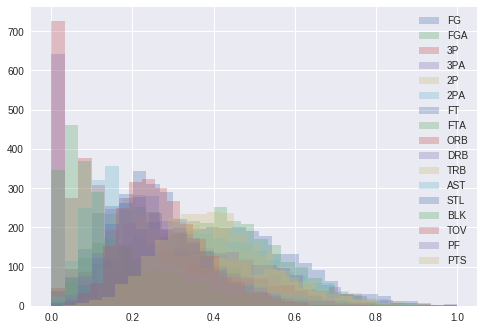

In [0]:
import matplotlib.pyplot as plt

x_train = dataset.x_train
x_cols = dataset.data_cols

for i, col in enumerate(x_cols):
  plt.hist(x_train[:, i], alpha=0.3, bins=30, label=col)
  plt.legend()
plt.show()

We define a subgraph of the full model, corresponding to a minibatch of size batch_size.

In [9]:
from src.vae import VAE

vae_mdl = VAE(hdims=[20], zdim=10, xdim=dataset.x_train.shape[1])

23/25 [ 92%] ███████████████████████████    ETA: 0s Epoch 1, Training loss: 21.79359873046875
24/25 [ 96%] ██████████████████████████

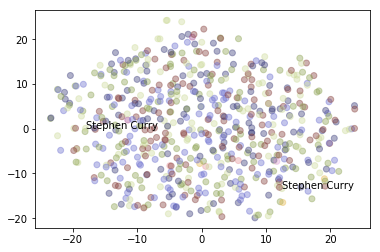

24/25 [ 96%] ████████████████████████████   ETA: 0sEpoch 11, Training loss: 3.7934

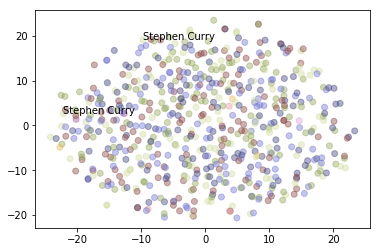

In [11]:
from src.viz_utils import convert_to_2d, plot_players

n_epochs = 20
n_val = 10
batch_size = 100

sess = ed.get_session()
tf.global_variables_initializer().run()

n_iter_per_epoch = dataset.x_train.shape[0] // batch_size + 1

for epoch in range(1, n_epochs+1):
    pbar = Progbar(n_iter_per_epoch)
    avg_loss = 0.
    
    for i, batch in enumerate(dataset.batch_train(batch_size)):
        pbar.update(i)
        info_dict = vae_mdl.inference.update(
            feed_dict={
                vae_mdl.x_ph: batch,
                vae_mdl.kl_coef: min(1., (epoch-1) + (i/n_iter_per_epoch)),
                vae_mdl.lr: 0.001
            }
        )
        avg_loss += info_dict['loss']
    
    avg_loss /= (n_iter_per_epoch * batch_size)
    print("Epoch {}, Training loss: {}".format(epoch, avg_loss))
    
    if epoch % n_val == 0:
        n_samples = 20
        x_test = dataset.x_test
        val_loss_, z_samples = sess.run([vae_mdl.eval_loss, vae_mdl.ops['inference']], 
                                         feed_dict={
                                             vae_mdl.x_ph: x_test, 
                                             vae_mdl.sample_size: n_samples,
                                             vae_mdl.kl_coef: 1.
                                         })
        
        print("-Validation logP(x) <= {}".format(val_loss_ / x_test.shape[0]))
        z_samples_2d = convert_to_2d(z_samples[::n_samples])
        plot_players(z_samples_2d, 
                     dataset.x_test_info, 
                     annotate_for=[{'player': 'Stephen Curry'}, {'player':'DeAndre Jordan'}, {'player': 'J.J. Reddick'}],
                     cmap='Vega20b')

While our VAE seems to optimize the lower bound somewhat, from visualizations, it seems that the latent space is not being used very well. This may be due to the fact that the innate latent structure of our data is multi-modal or too complex for a multivariate gaussian with a diagonal covariance matrix. While in theory, a large enough encoder and decoder should be able to compensate for the rigidity of the simple prior, in practice, it is difficult to train a complex VAE without overfitting.

Thus, in recent research, improvements have been made for increasing the expressivity of the prior. One such paper uses a GMM as a prior instead [[VaDE](https://arxiv.org/abs/1611.05148.pdf)]. Other researchers have begun to use normalizing flows (a set of reparameterizable and invertible transformations that fit well with the criteria for VAE priors) to transform the prior to something more suitable. Other potential improvements include an alternative objective that provides better bounds for our marginal likelihood.

# Deep Exponential Family: Sparse Gamma

We next try using a sparse Gamma deep exponential family model [[DEF]](http://www.cs.toronto.edu/~lcharlin/papers/def_aistats.pdf) on our data. 

For each of our data points, $x_n$, we have $L$ layers of hidden variables $\{z_{n,1}. . . z_{n,L}\}$. Also included in the model is a set of $L-1$ layers with weights $\{W_1, W_{L-1}\}$. Each of these is a matrix of independent variables with sparse gamma priors where each weight follows a $Gamma(a,b)$ distribution with $a<1$. The top layer of the latent variables is a vector with each element having a prior $z_{L,k} \sim Gamma (a_L, b_L)$.

The weights and layers are connected through:
> $p(z_{n,l,k} | z_{n,l+1},w_{l,k}) = Gamma(a_1, \frac{a_1}{z^T_{n,l+1}w_{l,k}}) $



We start by reading in our data  and scaling it.

In [0]:
df = pd.read_csv('./data/player_season_stats.csv', index_col=0)

# Use only recent stats and fill in missing values
df = df[df.Year >= 2011]
df = df.fillna(df.mean())

# Get rid of percentage and advanced derived stats
data_columns = [col for col in df.columns 
                 if not (('%' in col) 
                         or (col in 
                             ['PER', 'Age', 'OWS', 'DWS', 'WS', 'WS/48', 'BPM', 'VORP', '3PAr', 'FTr']
                            )
                        )]

total_data = df.drop_duplicates(subset=['Year', 'Player'], keep='first')[data_columns]
total_data = total_data[total_data.MP > 0]

# Standardize on minute and mean/variance
data_columns = ['FG', 'FGA', '3P', '3PA', '2P', '2PA', 'FT', 'FTA',
                'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']
for c in data_columns:
    total_data[c] = total_data[c].values / total_data['MP'].values

data = total_data.drop(['Year', 'Player', 'Pos', 'Tm', 'G', 'GS', 'MP'], axis=1)
data = StandardScaler(with_mean=False).fit_transform(data)

# Add small positive noise so that Gamma distribution support is met
noise = 1e-4
data += noise

We define our deep exponential family as above using 3 layers. We use default values of 0.1 for the scale and shape parameters of our Gamma distributions. 

In [6]:
import tensorflow as tf
import edward as ed
import numpy as np

from edward.models import Gamma, Poisson, PointMass
from edward.util import Progbar
from src.data_utils import BasketballDataset
from src.def_utils import pointmass_q, gamma_q

dataset = BasketballDataset('data/player_season_stats.csv', min_max=True)
data = dataset.x_train
    
scale = 0.1
shape = 0.1

z_shape = 0.1

K = [20, 20, 20]
D = data.shape[1]
N = data.shape[0]

x_ph = tf.placeholder(tf.float32, [N, D])

w2 = Gamma(scale, shape, sample_shape=[K[2], K[1]])
w1 = Gamma(scale, shape, sample_shape=[K[1], K[0]])
w0 = Gamma(scale, shape, sample_shape=[K[0], D])

z3 = Gamma(scale, shape, sample_shape=[N, K[2]])
z2 = Gamma(z_shape, z_shape / tf.matmul(z3, w2))
z1 = Gamma(z_shape, z_shape / tf.matmul(z2, w1))
x = Gamma(z_shape, z_shape / tf.matmul(z1, w0))

qw2 = pointmass_q(w2.shape)
qw1 = pointmass_q(w1.shape)
qw0 = pointmass_q(w0.shape)

qz3 = gamma_q(z3.shape)
qz2 = gamma_q(z2.shape)
qz1 = gamma_q(z1.shape)

lr = 0.001

Next we run variational inference:

In [8]:
inference_e = ed.KLqp({z1: qz1, z2: qz2, z3: qz3},
                      data={x: data, w2: qw2, w1: qw1, w0: qw0})
inference_m = ed.MAP({w2: qw2, w1: qw1, w0: qw0},
                     data={x: data, z3: qz3, z2: qz2, z1: qz1})
optimizer_e = tf.train.RMSPropOptimizer(lr)
optimizer_m = tf.train.RMSPropOptimizer(lr)

kwargs_e = dict(
    optimizer=optimizer_e,
    n_print=100
)

inference_e.initialize(**kwargs_e)
inference_m.initialize(optimizer=optimizer_m)

n_epoch = 300
n_iter_per_check = 50

sess = ed.get_session()
tf.global_variables_initializer().run()

pbar = Progbar(n_epoch)
train_ll = 0.
    
for epoch in range(n_epoch):
    pbar.update(epoch)
    
    info_dict_e = inference_e.update()
    info_dict_m = inference_m.update()
    
    batch_ll = sess.run(x.log_prob(x_ph), feed_dict={x_ph: dataset.x_train}) 
    train_ll += np.sum(batch_ll)
    
    if epoch % n_iter_per_check == 0:
        train_ll /= n_iter_per_check
        print("\nLog-likelihood at epoch {}: {}".format(epoch, train_ll))
        train_ll = 0

/home/roland/anaconda3/envs/ecbm4040/lib/python3.5/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


  0/300 [  0%]                                ETA: 0s
Log-likelihood at epoch 0: -1411.30953125
 50/300 [ 16%] █████                          ETA: 107s

# References
1. [[footballresearch2017](http://www.redalyc.org/pdf/710/71051616004.pdf)] Soto-Valero, César. "A Gaussian mixture clustering model for characterizing football players using
the EA Sports' FIFA video game system.""  Revista Internacional de Ciencias del Deporte, July 2017, Pages 244-259.

2. [[VAE]](https://arxiv.org/abs/1312.6114) Kingma, Diederik P., and Max Welling. "Auto-encoding variational bayes." arXiv preprint arXiv:1312.6114 (2013).

3. [[DEF]](http://www.cs.toronto.edu/~lcharlin/papers/def_aistats.pdf) Ranganath, Rajesh et al. "Deep Exponential Families." arXiv preprint arXiv:1411.2581 (2014).

4. [[VaDE]](https://arxiv.org/abs/1611.05148.pdf) "Variational Deep Embedding: An Unsupervised and Generative Approach to Clustering." arXiv preprint arXiv:1611.05148 (2016)